### Flux calibration module developed by N. Blagorodnova
Last updated on 24/04/2023.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob
from astropy.table import Table
from astropy import stats
from scipy.ndimage.filters import gaussian_filter1d
import astropy.units as u
from astropy import constants as cnt

/var/folders/09/qy8h4tn15bl78ybw9df8myd80000gn/T/ipykernel_3992/3074818918.py:7: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [3]:
#Define directory where your data are
DATADIR='/Users/nadiablago/Documents/Projects/LRN_candidates/AT2024gke/'

print(os.path.abspath(DATADIR))

/Users/nadiablago/Documents/Projects/LRN_candidates/AT2024gke


### Convert ABmags to Flux for STD star calibration

In [7]:
def from_mAB_2_fluxlam(fileabflux, plot=False):
    '''
    flieabflux. Flux of the standard star in AB magnitudes.
    The routine converts it to the usual units of erg/s/cm2/A.
    '''
    t = Table.read(fileabflux, format="ascii")
    wl = t['col1']
    flux_AB = t['col2']
    #fnu is in J and we convert it to cgs
    fnu = 10**((8.9 - flux_AB)/2.5)*(1e-23 * u.erg*u.s**-1 *u.Hz**-1 * u.cm**-2) 
    flam = (fnu * cnt.c / (wl*u.AA)**2).to(u.erg * u.cm**-2 * u.s**-1 * u.AA**-1)
    
    if plot:
        plt.plot(wl, flam, "o-", label="AB to flux")
        plt.ylabel("erg/cm2/s/A")
        plt.xlabel("Wavelength [$\\AA$]")
        
    return Table(np.array([wl, flam]).T, names=["wavelength", "flux"])


### Apply flux calibration routine
Reads the counts from the standard star and the real flux,
makes the conversion factor and applies it to the science expectrum.

In [8]:
def apply_flux_calibration(raw_science_file, raw_std_file, abs_flux_std_file, std_flux_mags=False, wmin=3600, wmax=9500):
    '''
    The code applies the flux calibration using the following steps.
    
     The code creates a ratio of abs_flux/raw_Std to create a sensitivity "spectrum" that is "flux per counts".
     Then it multiplies that by raw_science to obtain the absolute flux calibration for the science spectrum.


    "raw_science: an uncalibrated (i.e. unit of "counts" or similar) spectrum  
     raw_std: an uncalibrated standard star with the same observation setup
     abs_flux_std: a calibrated spectrum (i.e. in flux units). 

    '''
    
    plotdir = os.path.join(os.path.dirname(raw_science_file), "plots")
    if not os.path.isdir(plotdir):
        print ("Plots will be sotred in {}".format(plotdir))
        os.makedirs(plotdir)
    
    #Read the absolute flux from the standard star from a file.
    #It can be in AB magnitudes or in ergs/s/cm2/A
    if std_flux_mags:
        fluxstd = from_mAB_2_fluxlam(abs_flux_std_file)
    else:
        fluxstd = Table.read(abs_flux_std_file, format="ascii", names=('wavelength', 'flux', 'milli-Jy', 'bandpass'))
    #fluxstd.rename( 'ergs/cm2/s/A*10**-16', 'flux')
    print (fluxstd.colnames)
    wmin = np.maximum(np.min(fluxstd["wavelength"]), wmin)
    wmax = np.minimum(np.max(fluxstd["wavelength"]), wmax)
    print ("Consider between these wavelengths", wmin, wmax)

    #Read the raw science files from the fits file.
    if raw_science_file.endswith(".fits"):
        raw_science = fits.open(raw_science_file)
    else:
        raw_science = Table.read(raw_science_file)
    
    if len(raw_science) == 1:
        f = raw_science[0]
        flux = f.data[0]
        init = f.header["CRVAL1"]*1e10
        refpix = f.header["CRPIX1"]
        delta = f.header["CDELT1"]*1e10
        npix = f.header["NAXIS1"]
        exptime = f.header["EXPTIME"]
        wl = init + (np.arange(npix)+1. - refpix)*delta
        
        #create the table with the wavelength and raw flux in counts
        raw_science = Table(np.array([wl, flux]).T, names=["wavelength", "flux"])
        #Divide by total exposure time to convert to rates per second
        raw_science["flux"] = raw_science["flux"] / exptime
        
    elif len(raw_science) ==2:
        try:
            raw_science = Table(raw_science)
        except:
            raw_science = Table.read(raw_science_file, format="ascii")

    print(raw_science.colnames)
    w = raw_science["wavelength"]
    mask = (w>wmin)*(w<wmax)
    raw_science = raw_science[mask]

    #Read the raw STD files from the fits file.
    raw_std = fits.open(raw_std_file)

    if len(raw_std) == 1:
        f = raw_std[0]
        flux = f.data[0]
        init = f.header["CRVAL1"]*1e10
        refpix = f.header["CRPIX1"]
        delta = f.header["CDELT1"]*1e10
        npix = f.header["NAXIS1"]
        exptime = f.header["EXPTIME"]
        
        #create the table with the wavelength and raw flux in counts
        wl = init + (np.arange(npix)+1. - refpix)*delta
        #Divide by total exposure time to convert to rates per second
        raw_std = Table(np.array([wl, flux]).T, names=["wavelength", "flux"])
        raw_std["flux"] = raw_std["flux"]/exptime
        
    elif len(raw_std) ==2:
        try:
            f = raw_std[1]
            raw_std = f.data
            exptime = f.header["EXPTIME"]
            raw_std = Table(raw_std)
            print(raw_std.colnames)
        except:
            raw_std = Table.read(raw_science_file, format="ascii")
            
    w = raw_std["wavelength"]
    mask = (w>wmin)*(w<wmax)
    raw_std = raw_std[mask]


    plt.plot(raw_science["wavelength"], raw_science["flux"]/np.median(raw_science["flux"]), label="norm raw science counts/s")
    plt.plot(raw_std["wavelength"], raw_std["flux"]/np.median(raw_std["flux"]), label="norm raw std counts/s")
    plt.plot(fluxstd["wavelength"], fluxstd["flux"]/np.median(fluxstd["flux"]), label="norm abs std flux")
    plt.yscale("log")
    plt.xlabel("Wavelength")
    plt.ylabel("Scaled flux units")
    abs_flux_std = np.interp(raw_std["wavelength"], fluxstd["wavelength"], fluxstd["flux"])
    plt.legend()
    plt.savefig(os.path.join(plotdir, "raw_abs_flux.png"))
    
    sigma = 150 #Smoothing
    ams_per_pix = np.abs(np.median(w[1:]-w[0:-1]))
    sigma = sigma / ams_per_pix
    abs_flux_std_smooth = gaussian_filter1d(abs_flux_std, sigma)
    raw_flux_smooth = gaussian_filter1d(raw_std["flux"], sigma)

    
    factor =  abs_flux_std_smooth / raw_flux_smooth
    factor_sci = np.interp(raw_science["wavelength"], raw_std["wavelength"], factor)
    
    #The true flux is the raw counts multiplied by the factor
    science_abs = raw_science["flux"] * factor_sci

    
    #Write the calibrated flux to file
    mask = (raw_science["wavelength"]>wmin) * (raw_science["wavelength"] < wmax)
    wave_store = raw_science["wavelength"][mask]
    flux_calib_store = raw_science["flux"][mask] * factor_sci[mask]
    t = Table(np.array([wave_store, flux_calib_store]).T, names=["wavelength", "flux"])
    
    t.write(os.path.join(os.path.dirname(raw_science_file), \
                         os.path.basename(raw_science_file).replace(".fits", ".txt")), format="ascii", overwrite=True)
    
    

    #Plot the factor
    plt.figure()
    plt.plot(raw_science["wavelength"], factor_sci)
    plt.xlabel("Wavelength")
    plt.ylabel("Factor")
    plt.savefig(os.path.join(plotdir, "factor.png"))

    
    
    plt.figure()
    plt.plot(raw_std["wavelength"], raw_std["flux"] * factor, label="raw * factor")
    plt.plot(raw_std["wavelength"], abs_flux_std, label="abs flux")
    plt.plot(raw_std["wavelength"], abs_flux_std_smooth, label="abs smooth")
    ymin, ymax = plt.ylim()
    #Mark Balmer lines
    plt.vlines(6532, ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4861.33, ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4340.47, ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4101.76,ymin, ymax, color="k", linewidth=0.2)
    plt.legend()
    plt.yscale("log")
    plt.xlabel("Wavelength")
    plt.ylabel('ergs/cm2/s/A*10$^{-16}$')
    plt.savefig(os.path.join(plotdir, "std_flux.png"))


    z=0.003839
    
    #Plot Halpha in the STD star to verify wavelength calibration
    radius=100
    plt.figure()
    mask = np.abs(raw_std["wavelength"] - 6532*(1+z))<radius
    plt.plot(raw_std["wavelength"][mask], raw_std["flux"][mask], label="raw_std")
    #plt.xlim(6532*(1+z)-100, 6532*(1+z)+100)
    ymin, ymax = plt.ylim()
    plt.vlines(6532*(1+z), ymin, ymax, color="k", linewidth=0.2)
    plt.xlabel("Wavelength")
    plt.ylabel('ergs/cm2/s/A*10$^{-16}$')
    plt.title("Halpha region")
    plt.savefig(os.path.join(plotdir, "science_flux_halpha.png"))
    


    plt.figure()
    plt.plot(raw_science["wavelength"], raw_science["flux"] * factor_sci, label="raw * factor")
    ymin = np.min(raw_science["flux"] * factor_sci)
    ymax = np.max(raw_science["flux"] * factor_sci)
    plt.vlines(6532*(1+z), ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4861.33*(1+z), ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4340.47*(1+z), ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4101.76*(1+z),ymin, ymax, color="k", linewidth=0.2)
    plt.legend()
    plt.yscale("log")
    plt.xlabel("Wavelength")
    plt.ylabel('ergs/cm2/s/$\\AA$')
    plt.savefig(os.path.join(plotdir, "science_flux_1.png"))
    



In [9]:
#raw_science = os.path.join(DATADIR, "../spectra1D_dswfz_UB1_0001.fits")
raw_science = os.path.join(DATADIR, "spectra1D_AT2024gke_dswfz_uniB_0004.fits")

raw_std = os.path.join(DATADIR, "spectra1D_BD+33_2642_G200_dswfz_uniB_0122-2.fits")
abs_flux_std = "/Users/nadiablago/Documents/workspace/CAFOS_pipeline/data/std_flux/fbd33d2642.dat"

apply_flux_calibration(raw_science, raw_std, abs_flux_std, std_flux_mags=True, wmin=3800, wmax=9500)


KeyError: 'col1'

In [89]:
def sigma_clip(x, y, w=15, sigma=10):
    '''
    With a sliding window, of width of w Amstrongs
    it scans the spectrum and discards points that are 
    sigma standard deviations from the median value in the windown.
    '''
    
    yo = np.copy(y)
    wpix = w #np.ceil( 0.5 * w / (x[1]-x[0]))
    mask = np.repeat(False, len(yo))
    for i in np.arange(wpix, len(x[:-wpix])):
        m = np.median(yo[i-wpix:i+wpix])
        s = stats.funcs.median_absolute_deviation(yo[i-wpix:i+wpix])
        clip = np.abs(y[i] - m) > sigma*s
        mask[i-1:i+1] = mask[i-1:i+1] | clip
    if (np.count_nonzero(mask)>0):
        yo[mask] = np.interp(x[mask], x[~mask], yo[~mask])
    return yo

In [ ]:
def average_science(lfiles, merged_name, wmin=3600, wmax=9000):
    '''
    Reads the science spectrum from a list of files lfiles,
    sigma clips them, and makes an average spectrum.
    '''
    ave_flux = []
    plt.figure(figsize=(12,8))
    
    print ("Will combine all these spectra files: {}".format(lfiles))
    for raw_science_file in lfiles:
        raw_science = Table.read(raw_science_file, format="ascii")
        w = raw_science["wavelength"]
        mask = (w>wmin)*(w<wmax)
        raw_science = raw_science[mask]
        print (np.median(raw_science["flux"]))
        #Sigma clip
        raw_science["flux"] = sigma_clip(raw_science["wavelength"], raw_science["flux"], sigma=12)
        plt.plot(raw_science["wavelength"], raw_science["flux"], label="science", lw=0.3)
        ave_flux.append(raw_science["flux"])
        
    print (ave_flux)
    ave_flux=np.array(ave_flux)
    ave_flux = np.mean(ave_flux, axis=0)

    plt.plot(raw_science["wavelength"], ave_flux, label="average")
    plt.yscale("log")
    ymin, ymax = plt.ylim()
    plt.vlines(6532, ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4861.33, ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4340.47, ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4101.76,ymin, ymax, color="k", linewidth=0.2)
    plt.legend()
    
    t = Table(np.array([raw_science["wavelength"], ave_flux]).T, names=("wavelength", "flux"))
    t.write(os.path.join(DATADIR, mergedname), format="ascii", overwrite=True)
    print ("Written to ", os.path.join(DATADIR, merged_name))



In [ ]:
average_science(glob.glob(os.path.join(DATADIR, "*txt")), "AT2023uhx_CAFOS_20231026.txt", wmin=3900)

In [93]:
def median_science(lfiles, merged_name, wmin=3600, wmax=9000):
    '''
    Reads the science spectrum from a list of files lfiles,
    sigma clips them, and makes an average spectrum.
    '''
    ave_flux = []
    plt.figure(figsize=(12,8))
    
    print ("Will combine all these spectra files: {}".format(lfiles))
    for raw_science_file in lfiles:
        raw_science = Table.read(raw_science_file, format="ascii")
        w = raw_science["wavelength"]
        mask = (w>wmin)*(w<wmax)
        raw_science = raw_science[mask]
        print (np.median(raw_science["flux"]))
        #Sigma clip
        raw_science["flux"] = sigma_clip(raw_science["wavelength"], raw_science["flux"], sigma=12)
        plt.plot(raw_science["wavelength"], raw_science["flux"], label="science", lw=0.5)
        ave_flux.append(raw_science["flux"])
        
    print (ave_flux)
    ave_flux=np.array(ave_flux)
    ave_flux = np.median(ave_flux, axis=0)

    plt.plot(raw_science["wavelength"], ave_flux, label="median")
    plt.yscale("log")
    ymin, ymax = plt.ylim()
    plt.vlines(6532, ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4861.33, ymin, ymax, color="k", linewidth=0.4)
    plt.vlines(4340.47, ymin, ymax, color="k", linewidth=0.2)
    plt.vlines(4101.76,ymin, ymax, color="k", linewidth=0.2)
    plt.legend()
    
    t = Table(np.array([raw_science["wavelength"], ave_flux]).T, names=("wavelength", "flux"))
    t.write(os.path.join(DATADIR, merged_name), format="ascii", overwrite=True)
    print ("Written to ", os.path.join(DATADIR, merged_name))



Will combine all these spectra files: ['/Users/nadiablago/Documents/Projects/LRN_candidates/AT2024bch/AT2024bch_1.txt', '/Users/nadiablago/Documents/Projects/LRN_candidates/AT2024bch/AT2024bch_3.txt', '/Users/nadiablago/Documents/Projects/LRN_candidates/AT2024bch/AT2024bch_2.txt', '/Users/nadiablago/Documents/Projects/LRN_candidates/AT2024bch/AT2024bch.txt']
6.248921793382778e-15
6.5253481574411125e-15
6.312463349184146e-15
6.359921036637967e-15
[<Column name='flux' dtype='float64' length=996>
2.1518618274410803e-14
  2.15887063048662e-14
2.2000879554757224e-14
 2.208626443850545e-14
2.2576009121136628e-14
 2.241940966040948e-14
2.2822156489166457e-14
2.3475680884243077e-14
2.2921482634582523e-14
 2.357419843497688e-14
2.3905591197448664e-14
2.4386972602580048e-14
2.5072131532341904e-14
2.4329829090706425e-14
2.4377558220555207e-14
2.4964051601487588e-14
2.5049458823764833e-14
2.5041180571634154e-14
2.5614189046817848e-14
 2.595487134566583e-14
2.5751576647446974e-14
2.6092606843778133

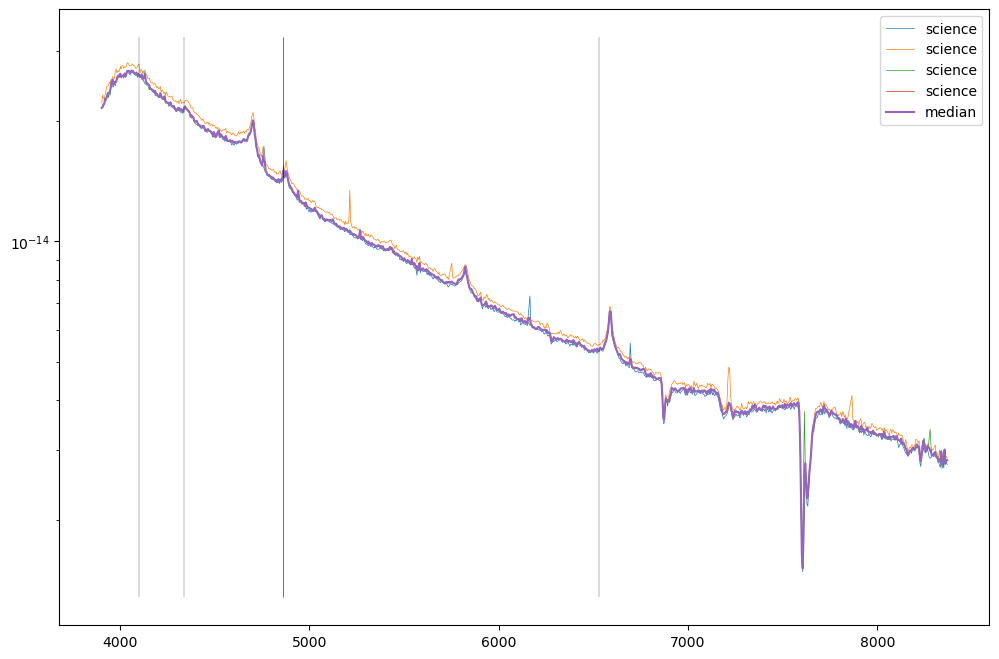

In [96]:
median_science(glob.glob(os.path.join(DATADIR, "*txt")), "AT2024bch.txt", wmin=3900)

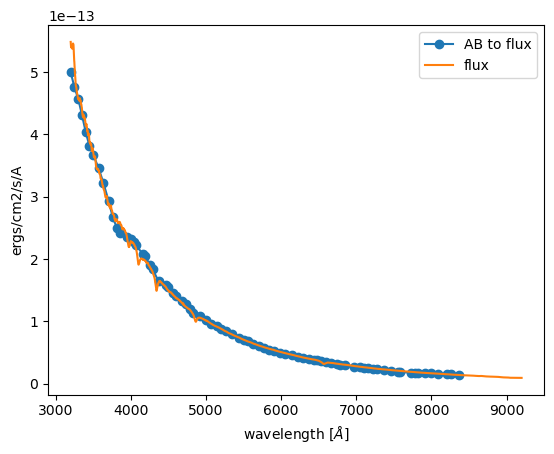

In [40]:
from_mAB_2_fluxlam(os.path.join("/Users/nadiablago/Documents/workspace/CAFOS_pipeline/std_flux", "g191b2b.dat"))

abs_flux_std_file = os.path.join("/Users/nadiablago/Documents/workspace/CAFOS_pipeline/std_flux", "fg191b2b.dat")
fluxstd = Table.read(abs_flux_std_file, format="ascii", names=('wavelength', 'flux', 'milli-Jy', 'bandpass'))
ax = plt.gca()
ax.plot(fluxstd['wavelength'], fluxstd['flux']*1e-16, label="flux")
ax.set_ylabel("ergs/cm2/s/A")
ax.set_xlabel("wavelength [$\\AA$]")
plt.legend()